# Optimization

## import some modules

In [1]:
from dftpy.ions import Ions
from dftpy.field import DirectField
from dftpy.grid import DirectGrid
from dftpy.functional import LocalPseudo, Functional, TotalFunctional
from dftpy.formats import io
from dftpy.math_utils import ecut2nr
from dftpy.time_data import TimeData
from dftpy.optimization import Optimization
from dftpy.mpi import sprint

## pseudopotential file

In [2]:
path_pp='../DATA/'
file1='Al_lda.oe01.recpot'
PP_list = {'Al': path_pp+file1}

## build the ions or read from file

In [3]:
from ase.build import bulk
atoms = bulk('Al', 'fcc', a=4.05, cubic=True)
ions = Ions.from_ase(atoms)
# ions = io.read(posfile)

## make a grid

In [4]:
nr = ecut2nr(ecut=35, lattice=ions.cell)
grid = DirectGrid(lattice=ions.cell, nr=nr)
sprint('The final grid size is ', nr)

The final grid size is  [20 20 20]


##  build local pseudo, and generate guess density

In [5]:
PSEUDO = LocalPseudo(grid = grid, ions=ions, PP_list=PP_list)

rho_ini = DirectField(grid=grid)
rho_ini[:] = ions.get_ncharges()/ions.cell.volume

setting key: Al -> ../DATA/Al_lda.oe01.recpot


## instance KEDF, XC and HARTREE functionals

In [6]:
KE = Functional(type='KEDF',name='TFvW')
XC = Functional(type='XC',name='LDA')
HARTREE = Functional(type='HARTREE')

## instance DFTpy evaluator

In [7]:
evaluator = TotalFunctional(KE=KE, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)

## instance and execute DFTpy density optimizer

In [8]:
optimization_options = {'econv' : 1e-6*ions.nat}
opt = Optimization(EnergyEvaluator=evaluator, optimization_options = optimization_options,
        optimization_method = 'TN')

rho = opt.optimize_rho(guess_rho=rho_ini)

Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       -8.090977705021E+00     -8.090978E+00   7.877088E-01    1       1       3.019786E-02    
1       -8.273226046266E+00     -1.822483E-01   7.033209E-02    2       1       4.573035E-02    
2       -8.280858134980E+00     -7.632089E-03   4.803545E-03    7       1       7.858968E-02    
3       -8.281101057269E+00     -2.429223E-04   3.640539E-04    5       1       1.080880E-01    
4       -8.281135973281E+00     -3.491601E-05   3.590568E-05    6       1       1.483943E-01    
5       -8.281138620008E+00     -2.646726E-06   2.500516E-06    5       1       1.792736E-01    
6       -8.281138990521E+00     -3.705134E-07   4.570800E-08    8       1       2.268357E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.3011519653615224
Chemical potential (eV)  : 8.194761599521389


## evaluate final energy

In [9]:
energy = evaluator.Energy(rho=rho, ions=ions)
print('Energy (a.u.)', energy)

Energy (a.u.) -8.281138990520986


##  print the timing

In [10]:
TimeData.output(lprint=True, sort='cost')

--------------------------------Time information--------------------------------
Label                       Cost(s)                 Number          Avg. Cost(s)            
ewald.Energy_corr           0.0001                  1               0.0001                  
CBspline._calc_PME_Qarray   0.0017                  1               0.0017                  
ewald.Energy_rec_PME        0.0026                  1               0.0026                  
LocalPseudo.local_PP        0.0029                  1               0.0029                  
ewald.Energy_real_fast2     0.0050                  1               0.0050                  
ewald.energy                0.0078                  41              0.0002                  
TF                          0.0196                  41              0.0005                  
InvFFT                      0.0225                  83              0.0003                  
FFT                         0.0277                  84              0.0003        

In [11]:
rho.write('rho.xsf', ions=ions)
rho.write('rho.cube', ions=ions)

## Visualize with scikit-image and matplotlib

!pip install scikit-image matplotlib

In [12]:
from dftpy.visualize import view

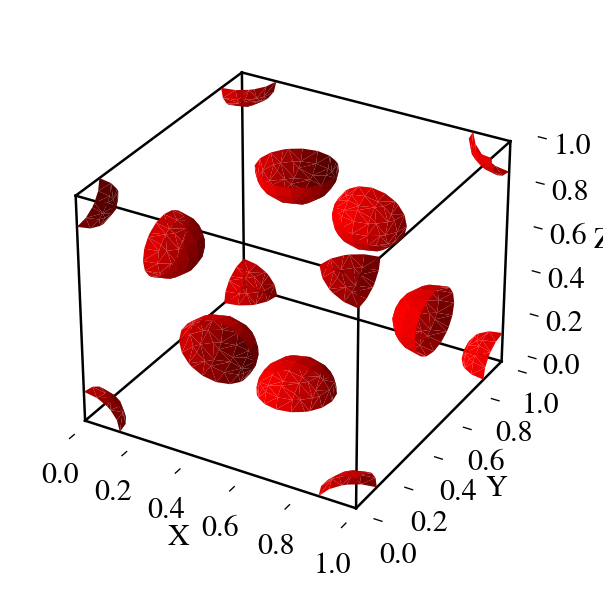

In [13]:
# %matplotlib widget
view(data=rho)

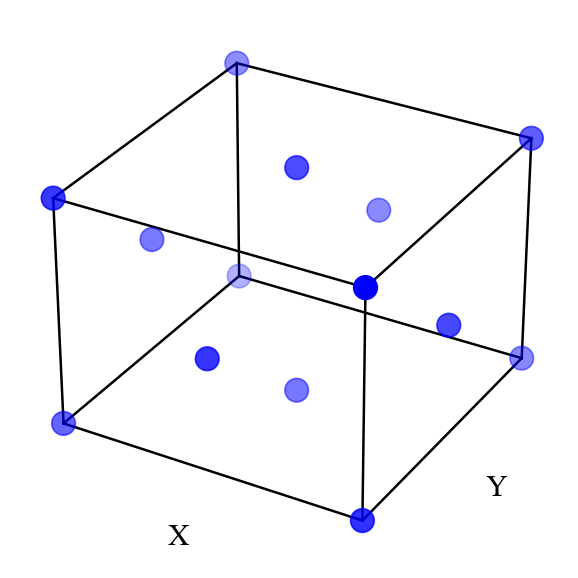

In [14]:
view(ions=ions)

## Visualize with VESTA

In [15]:
# view(ions=ions, data=rho, viewer='vesta')